# 2. Data exploration & Baseline model generation


In the previous notebook, the NY taxi trip data from Jan, Apr, July 2015 was loaded to a Postgis database called 'carto'.

In this notebook, some of the data will be used to create a GeoDataFrame.

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import contextily as ctx
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')
sns.despine()
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

# Task 1: Merge the taxi and ACS dataset by block group and compute the average number of pickups by block group


### Prepare data

Let's take pickup related features (pickup time, pickup point) from Jan 2015 taxi data as a sample to process.

A query will select pickup points from 'taxi_jan' table **only if the points is within any census blocks**. The result will be limited to 50,000 rows to reduce the size of the data table.

In [2]:
# Function to retrieve data from postgis as gdf (geo data frame) using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    
    # Close connection
    con.close()
    return gdf

In [10]:
# Query to select 50,000 pickup data from January 2015
# Geometric Point attribute will be created using longitude & latitude
q_jan = '''
        with
        
            jan as
            (
                select
                    tpep_pickup_datetime as pickup_time,
                    ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326)
                    as pickup_point
                from taxi_jan
            )
        
        select jan.*, census.geoid
        from jan, census_blocks as census
        where ST_Contains(census.geometry, jan.pickup_point)
        LIMIT 50000;
        '''

# Save the query result as a geodataframe
pickup_jan = get_gdf(q_jan, 'pickup_point')
pickup_jan.head()

,pickup_time,pickup_point,geoid
0,2015-01-06 13:41:17,POINT (-73.97626 40.73990),360610062001
1,2015-01-06 13:41:17,POINT (-74.00441 40.74870),360610099001
2,2015-01-14 01:53:40,POINT (-73.99359 40.74661),360610095001
3,2015-01-14 01:53:41,POINT (-74.00343 40.73279),360610073004
4,2015-01-14 01:53:42,POINT (-73.92319 40.74393),360810181021


In [11]:
# General information
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   50000 non-null  datetime64[ns]
 1   pickup_point  50000 non-null  geometry      
 2   geoid         50000 non-null  object        
dtypes: datetime64[ns](1), geometry(1), object(1)
memory usage: 1.1+ MB


**Note**:
* There are 50,000 records in this table without empty rows.
* The datatype for each column is well assigned.

Data from 31 days


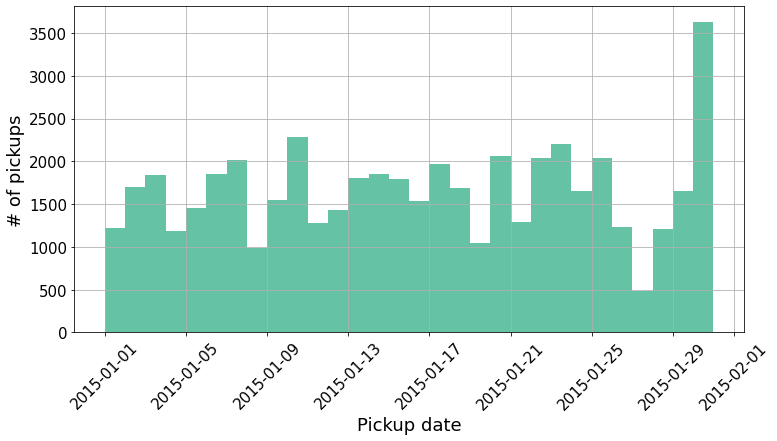

In [12]:
# Is the data from different dates of the month?
# Check the distribution of 'pickup_time' by assessing its datetime.date object.
dates_from_pickup_jan = pickup_jan.pickup_time.dt.date

print(f'Data from {len(dates_from_pickup_jan.unique())} days')

dates_from_pickup_jan.hist(bins=30, figsize=(12,6))
plt.ylabel('# of pickups')
plt.xlabel('Pickup date')
plt.xticks(rotation=45)
plt.show()

**Note**:
    
* The sample data we have was collected from day 1 to 31 of January, and despite daily variance, the amount of each day's pickup record is generally around 1,500.

In [13]:
# Remove duplicated rows if exist
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(49984, 3)

In [37]:
# How many taxi pickups in each geoid?
n_pickups = pickup_jan.groupby('geoid').pickup_point.count().sort_values(ascending=False)

# Result as DataFrame
n_pickups = pd.DataFrame(n_pickups)

# Rename the column name as 'n_pickups'
n_pickups = n_pickups.rename(columns={'pickup_point':'n_pickups'})

n_pickups.head()

,n_pickups
geoid,
360610101001,1240
360810331001,980
360810716001,913
360610092001,737
360610143001,661


**Note:**
    
    'n_pickups' from this table represents number of taxi pickups within a certain census block group ('geoid'). Therefore this 'n_pickups' column can be our target for the future baseline modeling.

array([[<AxesSubplot:title={'center':'n_pickups'}>]], dtype=object)

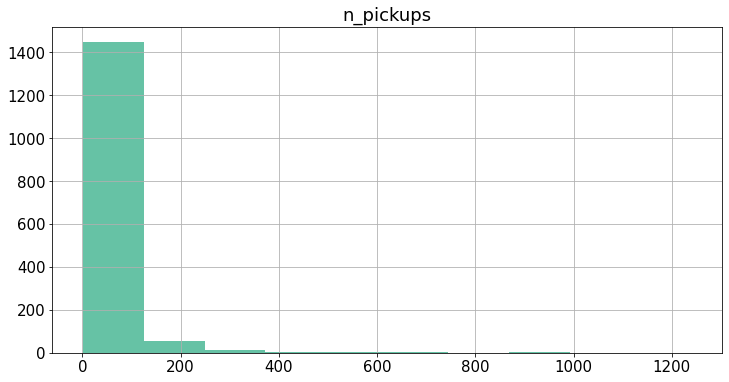

In [38]:
n_pickups.hist(figsize=(12,6))

In [39]:
# top 10 pickup_points
top_10_pickup_points = n_pickups[:10].index
top_10_pickup_points

Index(['360610101001', '360810331001', '360810716001', '360610092001',
       '360610143001', '360610099001', '360610113001', '360610102001',
       '360610094001', '360610058001'],
      dtype='object', name='geoid')

# Visualize the data

1. Prepare the census block group geomteries to plot together with pickup points.

2. Visualize all the pickup points on top of the census block polygons.

**1. Prepare the census block group geomteries to plot together with pickup points.**

In [40]:
# Load NYC census block group geometries to draw polygons
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')

# Sanity check: Are there missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [41]:
# Are all data types are correctly assigned?
census.dtypes

geoid         object
geometry    geometry
dtype: object

In [42]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

**2. Visualize all the pickup points from Jan, 2015 on top of the census block polygons**

In [43]:
# Print the current CRS (Coordinate Reference System)
print(f'Before: {pickup_jan.crs}, {census.crs}')

# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)
print(f'After: {pickup_jan.crs}, {census.crs}')

Before: epsg:3857, epsg:4326
After: epsg:3857, epsg:3857


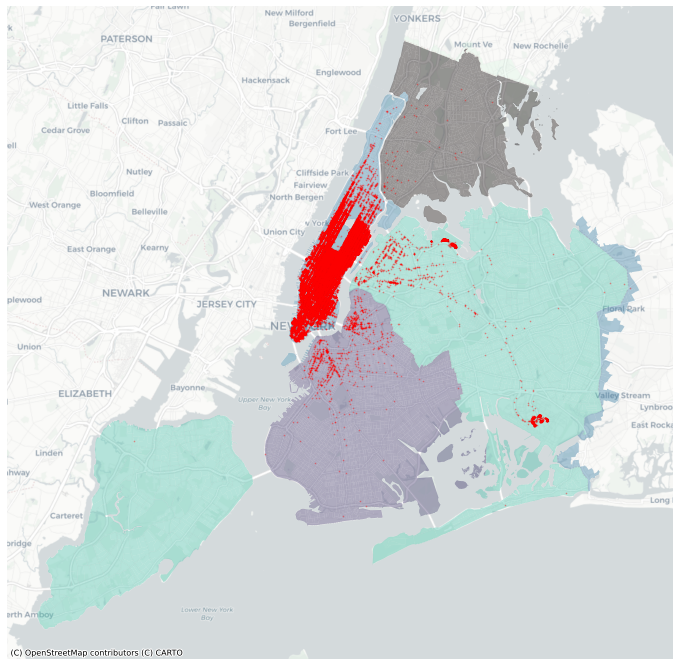

In [44]:
# Plot the census blocks (polygons)
ax = census.plot(column = 'geoid', figsize=(12, 12),
                 scheme='EqualInterval', alpha=.4, cmap='mako')

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.3, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

**Note**:
* The pickup points (red points) are heavily concentrated in Manhattan area.

**Visualize the top 10 pickup points**

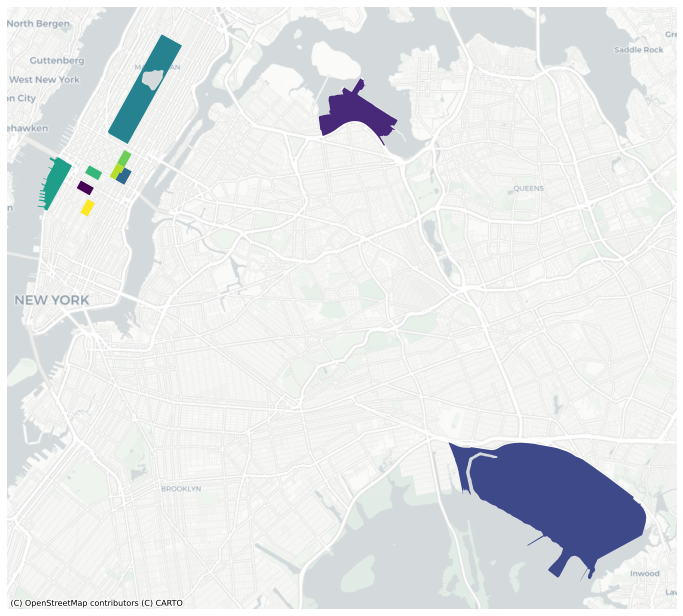

In [45]:
# Visualize census blocks with highest taxi pickups in Jan 15
# using geoindex of top 10 pickup points: top_10_pickup_points
# First, convert the index data type to numeric values
top_10_pickup_points = pd.to_numeric(top_10_pickup_points.values)

# Plot census blocks corresponding to these indices
ax = census.set_index('geoid') \
           .loc[top_10_pickup_points] \
           .plot(figsize=(12, 12), cmap='viridis')

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.show()

### Load more data:

Get New york's demographic & socio-economic (by census block group) dataset (.csv file) and check if there's any missing or duplicated rows from each data.

In [86]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [87]:
# Let's pivot the demographic table for convinience
demographic = demographic.pivot_table(values='value',
                                      index='geoid',
                                      columns='acs_demog_var')

print(demographic.shape)
demographic.head()

(6339, 33)


acs_demog_var,aggregate_travel_time_to_work,amerindian_pop,asian_pop,black_pop,commuters_16_over,commuters_by_public_transportation,employed_pop,families_with_young_children,family_households,female_pop,...,other_race_pop,owner_occupied_housing_units_median_value,pop_16_over,renter_occupied_housing_units_paying_cash_median_gross_rent,total_pop,two_or_more_races_pop,unemployed_pop,vacant_housing_units,vacant_housing_units_for_rent,white_pop
geoid,,,,,,,,,,,,,,,,,,,,,
360050001001,NaN,25.0,125.0,3984.0,0.0,0.0,0.0,0.0,0.0,577.0,...,38.0,NaN,7080.0,NaN,7080.0,41.0,0.0,0.0,0.0,538.0
360050002001,NaN,0.0,0.0,468.0,608.0,271.0,608.0,63.0,356.0,1024.0,...,0.0,384200.0,1543.0,1793.0,1919.0,0.0,168.0,30.0,0.0,13.0
360050002002,NaN,0.0,0.0,238.0,579.0,161.0,588.0,96.0,363.0,773.0,...,86.0,415300.0,1423.0,1358.0,1703.0,0.0,118.0,71.0,15.0,52.0
360050002003,NaN,0.0,104.0,202.0,382.0,108.0,382.0,33.0,239.0,481.0,...,0.0,374700.0,718.0,1677.0,920.0,0.0,9.0,57.0,0.0,12.0
360050004001,NaN,0.0,24.0,24.0,213.0,69.0,259.0,0.0,136.0,227.0,...,0.0,363900.0,417.0,1375.0,468.0,0.0,0.0,15.0,15.0,0.0


In [88]:
# Remove missing or duplicated rows
demographic = demographic[~demographic.isnull()]
demographic = demographic[~demographic.duplicated()]

In [89]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {demographic.isnull().any().sum()}')
print(f'How many duplicated rows?: {demographic.duplicated().sum()}')
print(demographic.shape)

How many rows with missing values?: 8
How many duplicated rows?: 0
(6279, 33)


In [90]:
# Are all data types are correctly assigned?
demographic.dtypes

acs_demog_var
aggregate_travel_time_to_work                                  float64
amerindian_pop                                                 float64
asian_pop                                                      float64
black_pop                                                      float64
commuters_16_over                                              float64
commuters_by_public_transportation                             float64
employed_pop                                                   float64
families_with_young_children                                   float64
family_households                                              float64
female_pop                                                     float64
hispanic_pop                                                   float64
households                                                     float64
housing_units                                                  float64
housing_units_renter_occupied                                  

# Task 2: Train a baseline model for the average number of pickups by block group using as covariates the ACS variables. 


* What is the performance of the model?
* What can we learn from this model?


Since the target n_pickup is a continuous variable, a linear regression algorithm is chosen as a baseline model. Columns from the demographic table will be used as features, n_pickups will be the target.

In [76]:
# Are all columns numeric?
demographic.dtypes

acs_demog_var
aggregate_travel_time_to_work                                  float64
amerindian_pop                                                 float64
asian_pop                                                      float64
black_pop                                                      float64
commuters_16_over                                              float64
commuters_by_public_transportation                             float64
employed_pop                                                   float64
families_with_young_children                                   float64
family_households                                              float64
female_pop                                                     float64
hispanic_pop                                                   float64
households                                                     float64
housing_units                                                  float64
housing_units_renter_occupied                                  

In [75]:
demographic.isnull().sum()

acs_demog_var
aggregate_travel_time_to_work                                  5917
amerindian_pop                                                    0
asian_pop                                                         0
black_pop                                                         0
commuters_16_over                                                 0
commuters_by_public_transportation                                0
employed_pop                                                      0
families_with_young_children                                      0
family_households                                                 0
female_pop                                                        0
hispanic_pop                                                      0
households                                                        0
housing_units                                                     0
housing_units_renter_occupied                                     0
income_per_capita                 

In [ ]:
# !!!!!!!!!!!! linear corr with the target ?

In [93]:
n_pickups.index = pd.to_numeric(n_pickups.index)

print(demographic.shape)
print(n_pickups.shape)

df = demographic.merge(n_pickups, on='geoid')
print(df.shape)

(6279, 33)
(1524, 1)
(1508, 34)


In [97]:
len(df.index.unique())

1508

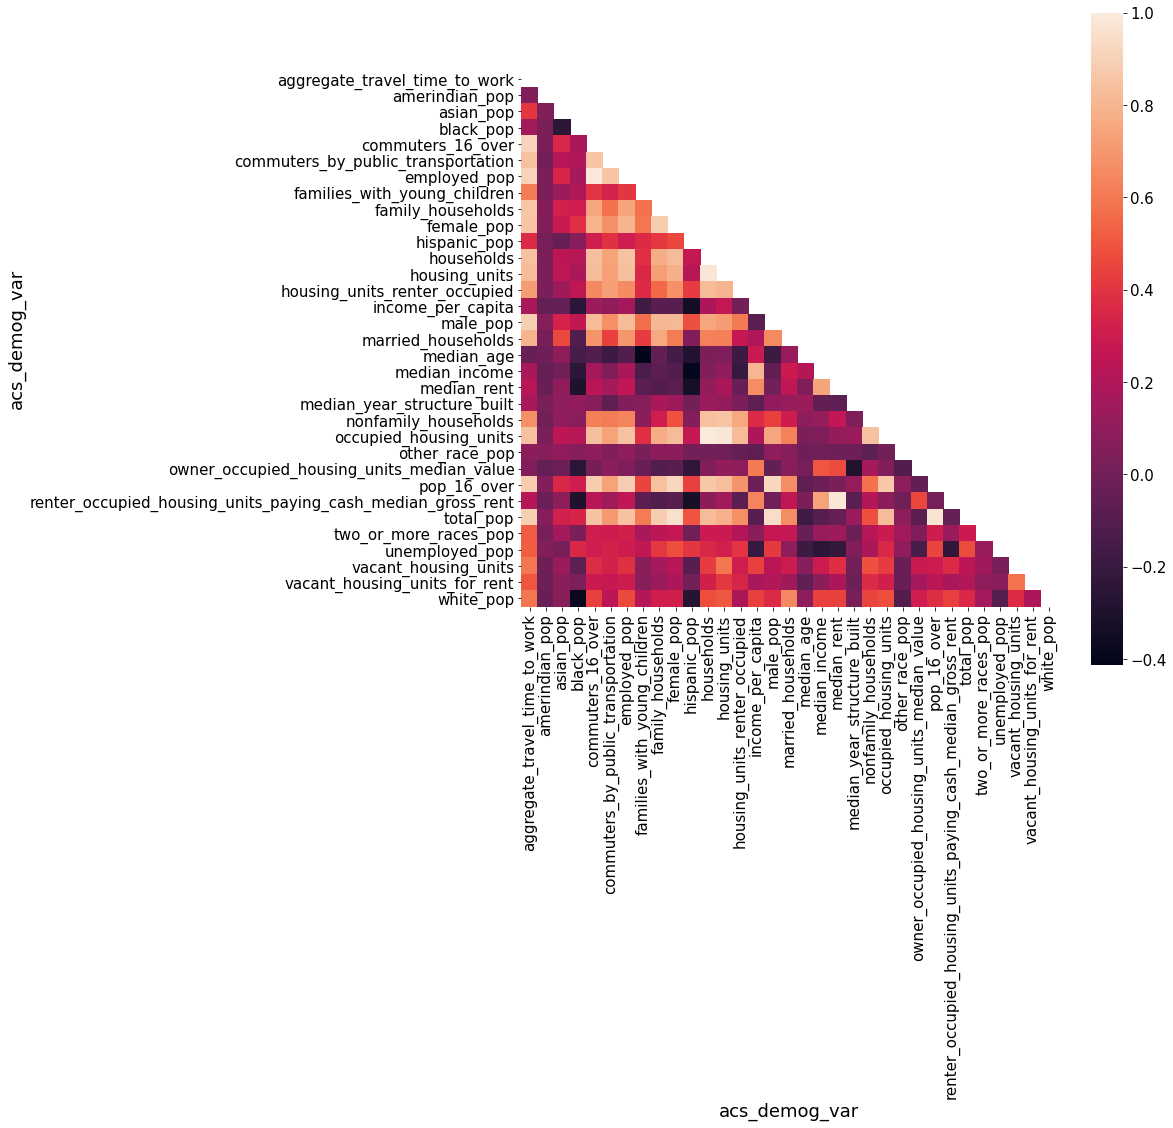

In [98]:
# Calculate correlation coeff
corr = demographic.corr()

# Confusion matrix
plt.figure(figsize=(12,12))
matrix = np.triu(corr)
sns.heatmap(corr, fmt='.1g', square=True, mask=matrix)
plt.show()

In [ ]:
# variable distribution


In [99]:
# Impute missing data using most_frequent values since this is just a baseline model
my_imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(my_imputer.fit_transform(df),
                             columns = df.columns)

df.isnull().any().sum()

0

In [106]:
target = 'n_pickups'
features = [col for col in df.columns if col != 'n_pickups']

In [107]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(df[features], # X
                                                    df[target], # y
                                                    test_size=0.3,
                                                    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1055, 33)
(453, 33)
(1055,)
(453,)


In [108]:
# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()